#### SGD Classifier

In [5]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import SGDClassifier

from src.paths import TRANSFORMED_DATA_DIR
from src.split_and_tfidf import split_and_vect
from src.stemming_and_lemming import stem_reviews

In [6]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR /'cleaned_sentiments.parquet')

In [7]:
df_copy = df.copy()

In [8]:
# split the data and fit a tfidf vectorizer to it
X_train_vec, X_test_vec, y_train, y_test, tfidf_vec = split_and_vect(df_copy, 'cleaned', 'recommended')

In [9]:
# sgd classifier
sgd = SGDClassifier()

# fit to tfidf vectorizer
sgd.fit(X_train_vec, y_train)

# make predictions
y_pred = sgd.predict(X_test_vec)

In [10]:
# metrics 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       503
           1       0.88      0.86      0.87       276

    accuracy                           0.91       779
   macro avg       0.90      0.90      0.90       779
weighted avg       0.91      0.91      0.91       779



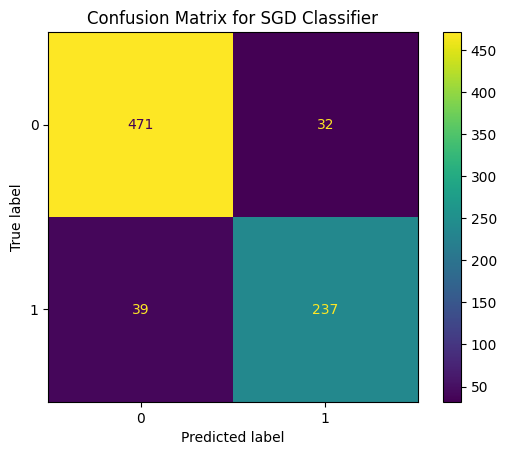

In [11]:
ConfusionMatrixDisplay.from_estimator(sgd, X_test_vec, y_test)
plt.title('Confusion Matrix for SGD Classifier')
plt.show()

In [12]:
# stemming
df_stem = df.copy()

# perform stemming on the data
df_stem['stemmed'] = stem_reviews(df_stem['cleaned'])

In [13]:
df_stem.tail()

,recommended,cleaned,stemmed
3887,0,Business LHR to BKK 747 400 First try back wit...,busi lhr to bkk 747 400 first tri back with ba...
3890,1,LHR to HAM Purser addresses all club passenger...,lhr to ham purser address all club passeng by ...
3891,0,My son who had worked for British Airways urge...,my son who had work for british airway urg me ...
3892,0,London City New York JFK via Shannon on A318 b...,london citi new york jfk via shannon on a318 b...
3893,0,SIN LHR BA12 B747 436 First Class Old aircraft...,sin lhr ba12 b747 436 first class old aircraft...


In [14]:
# split and vectorize
X_train_stem, X_test_stem, y_train, y_test, tfidf_stem_vec = split_and_vect(df_stem, 'stemmed', 'recommended')

# fit stemmed to sgd
# instantiate
sgd_stem = SGDClassifier()

# fit to the data
sgd_stem.fit(X_train_stem, y_train)

# make predictions
y_pred_stem = sgd_stem.predict(X_test_stem)


In [15]:
# metrics
print(classification_report(y_test, y_pred_stem))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       503
           1       0.89      0.87      0.88       276

    accuracy                           0.92       779
   macro avg       0.91      0.91      0.91       779
weighted avg       0.92      0.92      0.92       779



Text(0.5, 1.0, 'Confusion Matrix for SGD Classifier with Stemming')

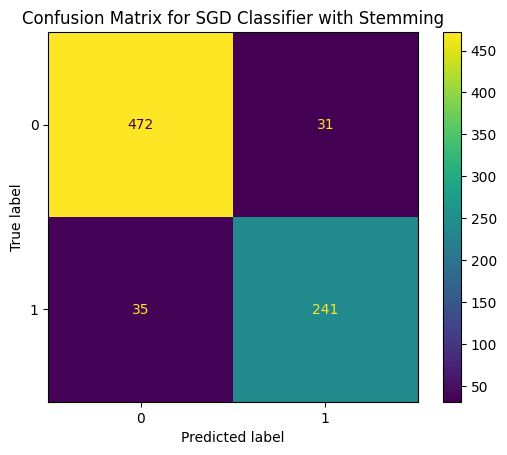

In [16]:
# confusion matrix
ConfusionMatrixDisplay.from_estimator(sgd_stem, X_test_stem, y_test)
plt.title('Confusion Matrix for SGD Classifier with Stemming')

#### Lemmatizing

In [17]:
# make a copy of the data
df_lemm = df.copy()

# lemmatize
from src.stemming_and_lemming import get_wordnet_pos, lemmatize_reviews

df_lemm['lemmatized'] = lemmatize_reviews(df['cleaned'])
df_lemm.head()

,recommended,cleaned,lemmatized
0,1,Very good flight following an equally good fli...,Very good flight follow an equally good flight...
1,1,An hours delay due to late arrival of the inco...,An hour delay due to late arrival of the incom...
2,0,I booked through BA because Loganair dont have...,I book through BA because Loganair dont have r...
3,0,British airways lost bags in LHR then found th...,British airway lose bag in LHR then find them ...
4,0,The check in process and reward loyalty progra...,The check in process and reward loyalty progra...


In [18]:
# split lemmatized data
X_train_lem, X_test_lem, y_train, y_test, tfidf_lem = split_and_vect(df_lemm, 'lemmatized', 'recommended')

# sgd classifier
sgd_lem = SGDClassifier()

# fit
sgd_lem.fit(X_train_lem, y_train)

# predict
y_pred_lem = sgd_lem.predict(X_test_lem)

# classification report
print(classification_report(y_test, y_pred_lem))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       503
           1       0.79      0.73      0.76       276

    accuracy                           0.84       779
   macro avg       0.83      0.81      0.82       779
weighted avg       0.84      0.84      0.84       779



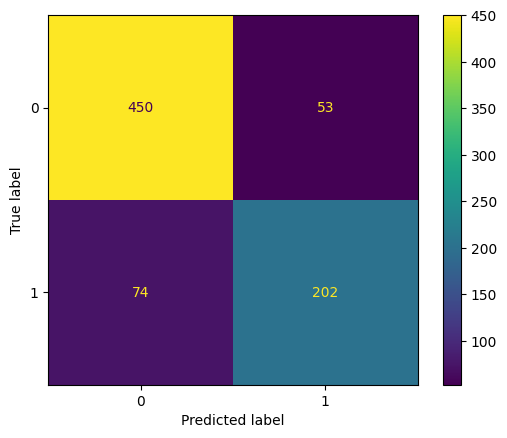

In [19]:
ConfusionMatrixDisplay.from_estimator(sgd_lem, X_test_lem, y_test)

### Hyperparameter Tuning with Optuna

In [20]:
import optuna
from sklearn.model_selection import cross_val_score

In [29]:
# create the optuna trial
def objective(trial: optuna.trial.Trial) -> float:
    '''Optuna Optimization Objective. Given the set of hyperparameters it will train a 
    model and return the average score based on cross-validation.'''
    # hyperparams
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }

    # create the model
    sgd_model = SGDClassifier(**hyperparams)

    # cross-val
    cross_val = cross_val_score(sgd_model, X_train_stem, y_train, cv = 3, scoring= 'accuracy')

    return cross_val.mean()


In [31]:
# run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-02-01 09:16:26,901] A new study created in memory with name: no-name-f3cb3760-affd-4637-934c-33e7db0f8967
[I 2025-02-01 09:16:27,500] Trial 0 finished with value: 0.6218298806408761 and parameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.004706485637730409, 'max_iter': 2630, 'learning_rate': 'adaptive', 'eta0': 0.09930736544720713, 'power_t': 0.6598381319500972}. Best is trial 0 with value: 0.6218298806408761.
[I 2025-02-01 09:16:27,955] Trial 1 finished with value: 0.6327381140034481 and parameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.006151733924289855, 'max_iter': 4419, 'learning_rate': 'adaptive', 'eta0': 0.08497716604577901, 'power_t': 0.30708807590169035}. Best is trial 1 with value: 0.6327381140034481.
[I 2025-02-01 09:16:28,016] Trial 2 finished with value: 0.6218298806408761 and parameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.009278681444879476, 'max_iter': 2813, 'learning_rate': 'optimal', 'eta0': 0.04702819457490698, 'power_t':

In [32]:
# best params
best_params = study.best_params
print(f'{best_params=}')

best_params={'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001113732214662295, 'max_iter': 1152, 'learning_rate': 'constant', 'eta0': 0.0593849935527394, 'power_t': 0.5928514866422264}


In [34]:
# fit model with new hyperparams
model_2 = SGDClassifier(**best_params)

model_2.fit(X_train_stem, y_train)

y_pred = model_2.predict(X_test_stem)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       503
           1       0.90      0.85      0.88       276

    accuracy                           0.91       779
   macro avg       0.91      0.90      0.90       779
weighted avg       0.91      0.91      0.91       779



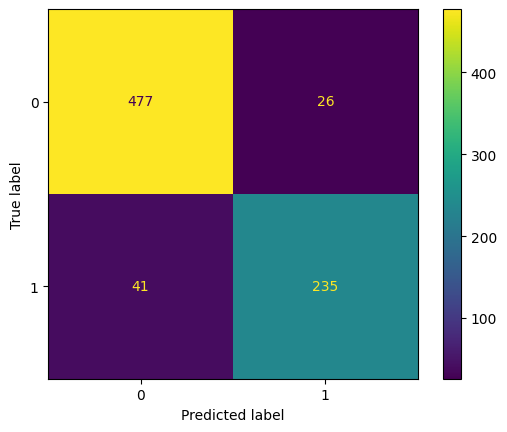

In [35]:
ConfusionMatrixDisplay.from_estimator(model_2, X_test_stem, y_test)

#### Adding Feature Selection Using Chi2

In [37]:
from src.pipeline import get_pipeline

import optuna
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Define the pipeline creation function
def get_pipeline(percentile: int, **hyperparams) -> Pipeline:
    '''Pipeline we use for our model.'''
    # Print statement
    print("Creating pipeline with hyperparameters:", hyperparams)
    # Print statement for feature selection
    print(f'Selecting best {percentile} percent of features.')
    # Create pipeline
    selector = SelectPercentile(chi2, percentile=percentile)
    pipeline = Pipeline([
        ('selector', selector),
        ('classifier', SGDClassifier(**hyperparams))
    ])
    print("Pipeline created.")
    return pipeline

# Objective function for Optuna
def objective(trial):
    # Suggest a value for the percentile
    percentile = trial.suggest_int('percentile', 10, 75)
    
    # Define hyperparameters in a dictionary
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }
    
    # Combine the percentile with hyperparameters
    best_params = {'percentile': percentile, **hyperparams}
    
    # Create the pipeline
    pipeline = get_pipeline(**best_params)
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train_stem, y_train, cv=3, scoring='accuracy')
    
    # Return the average accuracy
    return scores.mean()

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Create the pipeline with the best hyperparameters
pipeline = get_pipeline(**best_params)

# Fit the pipeline to the training data
pipeline.fit(X_train_stem, y_train)

# Make predictions and evaluate the model (optional)
predictions = pipeline.predict(X_test_stem)
print(classification_report(y_test, predictions))


[I 2025-02-01 12:25:31,665] A new study created in memory with name: no-name-c6dfdd9a-18cc-4721-8084-675f4a2f2dfb


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0005829244427346538, 'max_iter': 2214, 'learning_rate': 'constant', 'eta0': 0.016745512240156704, 'power_t': 0.5211765655947356}
Selecting best 42 percent of features.
Pipeline created.


[I 2025-02-01 12:25:33,379] Trial 0 finished with value: 0.8234360888730642 and parameters: {'percentile': 42, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0005829244427346538, 'max_iter': 2214, 'learning_rate': 'constant', 'eta0': 0.016745512240156704, 'power_t': 0.5211765655947356}. Best is trial 0 with value: 0.8234360888730642.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.002420311166072418, 'max_iter': 2068, 'learning_rate': 'adaptive', 'eta0': 0.03327590302693407, 'power_t': 0.6744936262774013}
Selecting best 14 percent of features.
Pipeline created.


[I 2025-02-01 12:25:35,114] Trial 1 finished with value: 0.7377236399556661 and parameters: {'percentile': 14, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.002420311166072418, 'max_iter': 2068, 'learning_rate': 'adaptive', 'eta0': 0.03327590302693407, 'power_t': 0.6744936262774013}. Best is trial 0 with value: 0.8234360888730642.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0037721993591669028, 'max_iter': 1985, 'learning_rate': 'optimal', 'eta0': 0.03049631191509987, 'power_t': 0.32298995042329826}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-01 12:25:36,204] Trial 2 finished with value: 0.6227932717776777 and parameters: {'percentile': 40, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0037721993591669028, 'max_iter': 1985, 'learning_rate': 'optimal', 'eta0': 0.03049631191509987, 'power_t': 0.32298995042329826}. Best is trial 0 with value: 0.8234360888730642.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.0019500172519747532, 'max_iter': 1477, 'learning_rate': 'optimal', 'eta0': 0.07649843125293955, 'power_t': 0.39401724164808144}
Selecting best 28 percent of features.
Pipeline created.


[I 2025-02-01 12:25:37,168] Trial 3 finished with value: 0.6658105250404426 and parameters: {'percentile': 28, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.0019500172519747532, 'max_iter': 1477, 'learning_rate': 'optimal', 'eta0': 0.07649843125293955, 'power_t': 0.39401724164808144}. Best is trial 0 with value: 0.8234360888730642.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008736484662122049, 'max_iter': 1864, 'learning_rate': 'invscaling', 'eta0': 0.008317749150654447, 'power_t': 0.6025852441961623}
Selecting best 28 percent of features.
Pipeline created.


[I 2025-02-01 12:25:38,202] Trial 4 finished with value: 0.6218298806408761 and parameters: {'percentile': 28, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008736484662122049, 'max_iter': 1864, 'learning_rate': 'invscaling', 'eta0': 0.008317749150654447, 'power_t': 0.6025852441961623}. Best is trial 0 with value: 0.8234360888730642.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0010553704998160118, 'max_iter': 4722, 'learning_rate': 'adaptive', 'eta0': 0.03124850653134344, 'power_t': 0.291277562465132}
Selecting best 36 percent of features.
Pipeline created.


[I 2025-02-01 12:25:39,248] Trial 5 finished with value: 0.8520102019937901 and parameters: {'percentile': 36, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0010553704998160118, 'max_iter': 4722, 'learning_rate': 'adaptive', 'eta0': 0.03124850653134344, 'power_t': 0.291277562465132}. Best is trial 5 with value: 0.8520102019937901.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.007202616149061618, 'max_iter': 1490, 'learning_rate': 'optimal', 'eta0': 0.09398383052484882, 'power_t': 0.705754146908864}
Selecting best 36 percent of features.
Pipeline created.


[I 2025-02-01 12:25:40,192] Trial 6 finished with value: 0.6218298806408761 and parameters: {'percentile': 36, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.007202616149061618, 'max_iter': 1490, 'learning_rate': 'optimal', 'eta0': 0.09398383052484882, 'power_t': 0.705754146908864}. Best is trial 5 with value: 0.8520102019937901.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.007635329862666151, 'max_iter': 1381, 'learning_rate': 'adaptive', 'eta0': 0.028697728908514863, 'power_t': 0.4285489998227978}
Selecting best 29 percent of features.
Pipeline created.


[I 2025-02-01 12:25:41,274] Trial 7 finished with value: 0.6218298806408761 and parameters: {'percentile': 29, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.007635329862666151, 'max_iter': 1381, 'learning_rate': 'adaptive', 'eta0': 0.028697728908514863, 'power_t': 0.4285489998227978}. Best is trial 5 with value: 0.8520102019937901.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.007482750972451295, 'max_iter': 4642, 'learning_rate': 'invscaling', 'eta0': 0.029112164408289808, 'power_t': 0.47954460823642603}
Selecting best 42 percent of features.
Pipeline created.


[I 2025-02-01 12:25:42,276] Trial 8 finished with value: 0.6218298806408761 and parameters: {'percentile': 42, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.007482750972451295, 'max_iter': 4642, 'learning_rate': 'invscaling', 'eta0': 0.029112164408289808, 'power_t': 0.47954460823642603}. Best is trial 5 with value: 0.8520102019937901.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.005308493394722684, 'max_iter': 4856, 'learning_rate': 'adaptive', 'eta0': 0.05672545422074794, 'power_t': 0.5149502613918013}
Selecting best 23 percent of features.
Pipeline created.


[I 2025-02-01 12:25:43,335] Trial 9 finished with value: 0.7659726047042664 and parameters: {'percentile': 23, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.005308493394722684, 'max_iter': 4856, 'learning_rate': 'adaptive', 'eta0': 0.05672545422074794, 'power_t': 0.5149502613918013}. Best is trial 5 with value: 0.8520102019937901.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0003416689062634167, 'max_iter': 3785, 'learning_rate': 'constant', 'eta0': 0.05723121800630534, 'power_t': 0.2944181504637296}
Selecting best 49 percent of features.
Pipeline created.


[I 2025-02-01 12:25:44,416] Trial 10 finished with value: 0.889246490282947 and parameters: {'percentile': 49, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0003416689062634167, 'max_iter': 3785, 'learning_rate': 'constant', 'eta0': 0.05723121800630534, 'power_t': 0.2944181504637296}. Best is trial 10 with value: 0.889246490282947.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0001339535913550041, 'max_iter': 3913, 'learning_rate': 'constant', 'eta0': 0.06086108731381075, 'power_t': 0.2990402128445641}
Selecting best 49 percent of features.
Pipeline created.


[I 2025-02-01 12:25:45,465] Trial 11 finished with value: 0.8908527603304149 and parameters: {'percentile': 49, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0001339535913550041, 'max_iter': 3913, 'learning_rate': 'constant', 'eta0': 0.06086108731381075, 'power_t': 0.2990402128445641}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00039601153354467284, 'max_iter': 3622, 'learning_rate': 'constant', 'eta0': 0.058015658432445154, 'power_t': 0.25026901870219515}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:25:46,481] Trial 12 finished with value: 0.8892474175121453 and parameters: {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00039601153354467284, 'max_iter': 3622, 'learning_rate': 'constant', 'eta0': 0.058015658432445154, 'power_t': 0.25026901870219515}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0032326004637544038, 'max_iter': 3454, 'learning_rate': 'constant', 'eta0': 0.07265547618264885, 'power_t': 0.2644150729199049}
Selecting best 49 percent of features.
Pipeline created.


[I 2025-02-01 12:25:47,490] Trial 13 finished with value: 0.6626010757095003 and parameters: {'percentile': 49, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0032326004637544038, 'max_iter': 3454, 'learning_rate': 'constant', 'eta0': 0.07265547618264885, 'power_t': 0.2644150729199049}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00447675107562775, 'max_iter': 4024, 'learning_rate': 'constant', 'eta0': 0.07129542062374096, 'power_t': 0.37013929760681696}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:25:48,506] Trial 14 finished with value: 0.6250402572010165 and parameters: {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00447675107562775, 'max_iter': 4024, 'learning_rate': 'constant', 'eta0': 0.07129542062374096, 'power_t': 0.37013929760681696}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0017633987319501947, 'max_iter': 2968, 'learning_rate': 'constant', 'eta0': 0.047649741676555155, 'power_t': 0.34798119232624647}
Selecting best 44 percent of features.
Pipeline created.


[I 2025-02-01 12:25:49,526] Trial 15 finished with value: 0.8035352776711463 and parameters: {'percentile': 44, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0017633987319501947, 'max_iter': 2968, 'learning_rate': 'constant', 'eta0': 0.047649741676555155, 'power_t': 0.34798119232624647}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.005548288277641234, 'max_iter': 2878, 'learning_rate': 'constant', 'eta0': 0.09202817677904232, 'power_t': 0.25384718862861916}
Selecting best 14 percent of features.
Pipeline created.


[I 2025-02-01 12:25:50,570] Trial 16 finished with value: 0.6218298806408761 and parameters: {'percentile': 14, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.005548288277641234, 'max_iter': 2878, 'learning_rate': 'constant', 'eta0': 0.09202817677904232, 'power_t': 0.25384718862861916}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00011946801656360261, 'max_iter': 4120, 'learning_rate': 'constant', 'eta0': 0.050427649041982416, 'power_t': 0.44603328282410903}
Selecting best 35 percent of features.
Pipeline created.


[I 2025-02-01 12:25:51,632] Trial 17 finished with value: 0.8841093314492037 and parameters: {'percentile': 35, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00011946801656360261, 'max_iter': 4120, 'learning_rate': 'constant', 'eta0': 0.050427649041982416, 'power_t': 0.44603328282410903}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0027830292679064473, 'max_iter': 3428, 'learning_rate': 'constant', 'eta0': 0.08267650626853726, 'power_t': 0.5718987771093137}
Selecting best 45 percent of features.
Pipeline created.


[I 2025-02-01 12:25:52,694] Trial 18 finished with value: 0.6950268989190361 and parameters: {'percentile': 45, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0027830292679064473, 'max_iter': 3428, 'learning_rate': 'constant', 'eta0': 0.08267650626853726, 'power_t': 0.5718987771093137}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0013214671730648721, 'max_iter': 2687, 'learning_rate': 'invscaling', 'eta0': 0.06247497966779405, 'power_t': 0.32624236281317975}
Selecting best 46 percent of features.
Pipeline created.


[I 2025-02-01 12:25:54,026] Trial 19 finished with value: 0.6266449818664878 and parameters: {'percentile': 46, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0013214671730648721, 'max_iter': 2687, 'learning_rate': 'invscaling', 'eta0': 0.06247497966779405, 'power_t': 0.32624236281317975}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0063410901530672375, 'max_iter': 4341, 'learning_rate': 'constant', 'eta0': 0.04270428758938159, 'power_t': 0.40202436491805854}
Selecting best 20 percent of features.
Pipeline created.


[I 2025-02-01 12:25:55,077] Trial 20 finished with value: 0.8051359843434259 and parameters: {'percentile': 20, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0063410901530672375, 'max_iter': 4341, 'learning_rate': 'constant', 'eta0': 0.04270428758938159, 'power_t': 0.40202436491805854}. Best is trial 11 with value: 0.8908527603304149.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00022432809064300567, 'max_iter': 3588, 'learning_rate': 'constant', 'eta0': 0.06247358211336947, 'power_t': 0.30237348745881604}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:25:56,184] Trial 21 finished with value: 0.8911732725565501 and parameters: {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00022432809064300567, 'max_iter': 3588, 'learning_rate': 'constant', 'eta0': 0.06247358211336947, 'power_t': 0.30237348745881604}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00117584254054423, 'max_iter': 3496, 'learning_rate': 'constant', 'eta0': 0.06594517068625008, 'power_t': 0.30633386261872547}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:25:57,248] Trial 22 finished with value: 0.8462329459369743 and parameters: {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00117584254054423, 'max_iter': 3496, 'learning_rate': 'constant', 'eta0': 0.06594517068625008, 'power_t': 0.30633386261872547}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0002248976736868989, 'max_iter': 3757, 'learning_rate': 'constant', 'eta0': 0.0827845899831368, 'power_t': 0.2617838385304522}
Selecting best 39 percent of features.
Pipeline created.


[I 2025-02-01 12:25:58,351] Trial 23 finished with value: 0.8869998139360075 and parameters: {'percentile': 39, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0002248976736868989, 'max_iter': 3757, 'learning_rate': 'constant', 'eta0': 0.0827845899831368, 'power_t': 0.2617838385304522}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.009897785025302114, 'max_iter': 3272, 'learning_rate': 'constant', 'eta0': 0.04113480633801696, 'power_t': 0.3631811355586993}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-01 12:25:59,421] Trial 24 finished with value: 0.6218298806408761 and parameters: {'percentile': 47, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.009897785025302114, 'max_iter': 3272, 'learning_rate': 'constant', 'eta0': 0.04113480633801696, 'power_t': 0.3631811355586993}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.002044106064325708, 'max_iter': 2469, 'learning_rate': 'constant', 'eta0': 0.05956860580327256, 'power_t': 0.3396852703112128}
Selecting best 46 percent of features.
Pipeline created.


[I 2025-02-01 12:26:00,489] Trial 25 finished with value: 0.7791364776293593 and parameters: {'percentile': 46, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.002044106064325708, 'max_iter': 2469, 'learning_rate': 'constant', 'eta0': 0.05956860580327256, 'power_t': 0.3396852703112128}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0033623166558198235, 'max_iter': 4270, 'learning_rate': 'constant', 'eta0': 0.06735116271641955, 'power_t': 0.2854156743891812}
Selecting best 33 percent of features.
Pipeline created.


[I 2025-02-01 12:26:01,537] Trial 26 finished with value: 0.6507232696821396 and parameters: {'percentile': 33, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0033623166558198235, 'max_iter': 4270, 'learning_rate': 'constant', 'eta0': 0.06735116271641955, 'power_t': 0.2854156743891812}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0010982572077723792, 'max_iter': 3179, 'learning_rate': 'invscaling', 'eta0': 0.07980179236841417, 'power_t': 0.4009587477918124}
Selecting best 42 percent of features.
Pipeline created.


[I 2025-02-01 12:26:02,683] Trial 27 finished with value: 0.625362005732749 and parameters: {'percentile': 42, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0010982572077723792, 'max_iter': 3179, 'learning_rate': 'invscaling', 'eta0': 0.07980179236841417, 'power_t': 0.4009587477918124}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0007199117989660618, 'max_iter': 3801, 'learning_rate': 'optimal', 'eta0': 0.053129287131565714, 'power_t': 0.4592501731351446}
Selecting best 38 percent of features.
Pipeline created.


[I 2025-02-01 12:26:03,728] Trial 28 finished with value: 0.8324265031776145 and parameters: {'percentile': 38, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0007199117989660618, 'max_iter': 3801, 'learning_rate': 'optimal', 'eta0': 0.053129287131565714, 'power_t': 0.4592501731351446}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.004535670115705727, 'max_iter': 4436, 'learning_rate': 'constant', 'eta0': 0.04468930131859355, 'power_t': 0.5593095880073607}
Selecting best 43 percent of features.
Pipeline created.


[I 2025-02-01 12:26:04,931] Trial 29 finished with value: 0.8093119155751634 and parameters: {'percentile': 43, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.004535670115705727, 'max_iter': 4436, 'learning_rate': 'constant', 'eta0': 0.04468930131859355, 'power_t': 0.5593095880073607}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0016723944382124657, 'max_iter': 3665, 'learning_rate': 'constant', 'eta0': 0.03844163519756493, 'power_t': 0.2513457692828936}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-01 12:26:06,174] Trial 30 finished with value: 0.7393302190795333 and parameters: {'percentile': 47, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0016723944382124657, 'max_iter': 3665, 'learning_rate': 'constant', 'eta0': 0.03844163519756493, 'power_t': 0.2513457692828936}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00016792686734426986, 'max_iter': 3946, 'learning_rate': 'constant', 'eta0': 0.05675832448394022, 'power_t': 0.30792226645811216}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-01 12:26:07,322] Trial 31 finished with value: 0.8892480356649438 and parameters: {'percentile': 48, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00016792686734426986, 'max_iter': 3946, 'learning_rate': 'constant', 'eta0': 0.05675832448394022, 'power_t': 0.30792226645811216}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0007671106642242996, 'max_iter': 4048, 'learning_rate': 'constant', 'eta0': 0.06603933593928571, 'power_t': 0.3191543825236822}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:26:08,436] Trial 32 finished with value: 0.8735172832431758 and parameters: {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0007671106642242996, 'max_iter': 4048, 'learning_rate': 'constant', 'eta0': 0.06603933593928571, 'power_t': 0.3191543825236822}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.002493714944600232, 'max_iter': 3162, 'learning_rate': 'constant', 'eta0': 0.053621262609651235, 'power_t': 0.28642869085098394}
Selecting best 11 percent of features.
Pipeline created.


[I 2025-02-01 12:26:09,468] Trial 33 finished with value: 0.7104374481910686 and parameters: {'percentile': 11, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.002493714944600232, 'max_iter': 3162, 'learning_rate': 'constant', 'eta0': 0.053621262609651235, 'power_t': 0.28642869085098394}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00012425560528179827, 'max_iter': 3953, 'learning_rate': 'constant', 'eta0': 0.020988818607089, 'power_t': 0.3618976924235394}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-01 12:26:10,664] Trial 34 finished with value: 0.8908521421776164 and parameters: {'percentile': 47, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00012425560528179827, 'max_iter': 3953, 'learning_rate': 'constant', 'eta0': 0.020988818607089, 'power_t': 0.3618976924235394}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.001515299602323834, 'max_iter': 3931, 'learning_rate': 'optimal', 'eta0': 0.02039623687410265, 'power_t': 0.3692438580888469}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-01 12:26:11,857] Trial 35 finished with value: 0.7698283327862682 and parameters: {'percentile': 40, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.001515299602323834, 'max_iter': 3931, 'learning_rate': 'optimal', 'eta0': 0.02039623687410265, 'power_t': 0.3692438580888469}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00010224862453083566, 'max_iter': 4504, 'learning_rate': 'adaptive', 'eta0': 0.004313535778040157, 'power_t': 0.3376507711634489}
Selecting best 41 percent of features.
Pipeline created.


[I 2025-02-01 12:26:13,671] Trial 36 finished with value: 0.8211900306789234 and parameters: {'percentile': 41, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00010224862453083566, 'max_iter': 4504, 'learning_rate': 'adaptive', 'eta0': 0.004313535778040157, 'power_t': 0.3376507711634489}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.002285796295396231, 'max_iter': 4963, 'learning_rate': 'constant', 'eta0': 0.016313185983910915, 'power_t': 0.6489847221390523}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-01 12:26:14,817] Trial 37 finished with value: 0.7576266146923794 and parameters: {'percentile': 47, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.002285796295396231, 'max_iter': 4963, 'learning_rate': 'constant', 'eta0': 0.016313185983910915, 'power_t': 0.6489847221390523}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0007223990971118156, 'max_iter': 4177, 'learning_rate': 'optimal', 'eta0': 0.01804879437061929, 'power_t': 0.4194282965054168}
Selecting best 24 percent of features.
Pipeline created.


[I 2025-02-01 12:26:15,951] Trial 38 finished with value: 0.866453960288628 and parameters: {'percentile': 24, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0007223990971118156, 'max_iter': 4177, 'learning_rate': 'optimal', 'eta0': 0.01804879437061929, 'power_t': 0.4194282965054168}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.0028782735972935946, 'max_iter': 3897, 'learning_rate': 'invscaling', 'eta0': 0.023872160096762327, 'power_t': 0.38187834053643327}
Selecting best 44 percent of features.
Pipeline created.


[I 2025-02-01 12:26:17,105] Trial 39 finished with value: 0.6218298806408761 and parameters: {'percentile': 44, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.0028782735972935946, 'max_iter': 3897, 'learning_rate': 'invscaling', 'eta0': 0.023872160096762327, 'power_t': 0.38187834053643327}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009983820840121552, 'max_iter': 4644, 'learning_rate': 'adaptive', 'eta0': 0.011855359461406992, 'power_t': 0.30183239780164}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-01 12:26:18,708] Trial 40 finished with value: 0.8770481720294514 and parameters: {'percentile': 48, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009983820840121552, 'max_iter': 4644, 'learning_rate': 'adaptive', 'eta0': 0.011855359461406992, 'power_t': 0.30183239780164}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.000641049303882887, 'max_iter': 3567, 'learning_rate': 'constant', 'eta0': 0.03535041710816088, 'power_t': 0.28120604521725007}
Selecting best 45 percent of features.
Pipeline created.


[I 2025-02-01 12:26:19,869] Trial 41 finished with value: 0.8786544420769192 and parameters: {'percentile': 45, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.000641049303882887, 'max_iter': 3567, 'learning_rate': 'constant', 'eta0': 0.03535041710816088, 'power_t': 0.28120604521725007}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0005248675312921633, 'max_iter': 3350, 'learning_rate': 'constant', 'eta0': 0.06255589943609259, 'power_t': 0.31504449383315036}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-01 12:26:21,044] Trial 42 finished with value: 0.8837900555286659 and parameters: {'percentile': 48, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0005248675312921633, 'max_iter': 3350, 'learning_rate': 'constant', 'eta0': 0.06255589943609259, 'power_t': 0.31504449383315036}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0016724853310765935, 'max_iter': 3647, 'learning_rate': 'constant', 'eta0': 0.04984045868131335, 'power_t': 0.749873120109847}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:26:22,179] Trial 43 finished with value: 0.8154146290805039 and parameters: {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0016724853310765935, 'max_iter': 3647, 'learning_rate': 'constant', 'eta0': 0.04984045868131335, 'power_t': 0.749873120109847}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0001594256744285233, 'max_iter': 4216, 'learning_rate': 'constant', 'eta0': 0.07301814535885995, 'power_t': 0.34835682438572235}
Selecting best 43 percent of features.
Pipeline created.


[I 2025-02-01 12:26:23,359] Trial 44 finished with value: 0.8876430019230733 and parameters: {'percentile': 43, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0001594256744285233, 'max_iter': 4216, 'learning_rate': 'constant', 'eta0': 0.07301814535885995, 'power_t': 0.34835682438572235}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0013248244286595944, 'max_iter': 3933, 'learning_rate': 'constant', 'eta0': 0.05626794955313063, 'power_t': 0.2778730662502363}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-01 12:26:24,526] Trial 45 finished with value: 0.8369229466354869 and parameters: {'percentile': 48, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0013248244286595944, 'max_iter': 3933, 'learning_rate': 'constant', 'eta0': 0.05626794955313063, 'power_t': 0.2778730662502363}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0006401484476776258, 'max_iter': 2820, 'learning_rate': 'adaptive', 'eta0': 0.061274861338830276, 'power_t': 0.3097654654829155}
Selecting best 46 percent of features.
Pipeline created.


[I 2025-02-01 12:26:25,757] Trial 46 finished with value: 0.8799377272870572 and parameters: {'percentile': 46, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0006401484476776258, 'max_iter': 2820, 'learning_rate': 'adaptive', 'eta0': 0.061274861338830276, 'power_t': 0.3097654654829155}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0020600922047461284, 'max_iter': 1098, 'learning_rate': 'constant', 'eta0': 0.07577486940292395, 'power_t': 0.2502919507648373}
Selecting best 31 percent of features.
Pipeline created.


[I 2025-02-01 12:26:26,887] Trial 47 finished with value: 0.7714318211461418 and parameters: {'percentile': 31, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0020600922047461284, 'max_iter': 1098, 'learning_rate': 'constant', 'eta0': 0.07577486940292395, 'power_t': 0.2502919507648373}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.003774232416324565, 'max_iter': 3104, 'learning_rate': 'constant', 'eta0': 0.047155078977572956, 'power_t': 0.493155035101434}
Selecting best 37 percent of features.
Pipeline created.


[I 2025-02-01 12:26:28,080] Trial 48 finished with value: 0.6218298806408761 and parameters: {'percentile': 37, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.003774232416324565, 'max_iter': 3104, 'learning_rate': 'constant', 'eta0': 0.047155078977572956, 'power_t': 0.493155035101434}. Best is trial 21 with value: 0.8911732725565501.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00098448666374093, 'max_iter': 3658, 'learning_rate': 'invscaling', 'eta0': 0.07025720116813763, 'power_t': 0.35394126093892075}
Selecting best 49 percent of features.
Pipeline created.


[I 2025-02-01 12:26:29,431] Trial 49 finished with value: 0.7049763772907971 and parameters: {'percentile': 49, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00098448666374093, 'max_iter': 3658, 'learning_rate': 'invscaling', 'eta0': 0.07025720116813763, 'power_t': 0.35394126093892075}. Best is trial 21 with value: 0.8911732725565501.


Best hyperparameters:  {'percentile': 50, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00022432809064300567, 'max_iter': 3588, 'learning_rate': 'constant', 'eta0': 0.06247358211336947, 'power_t': 0.30237348745881604}
Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00022432809064300567, 'max_iter': 3588, 'learning_rate': 'constant', 'eta0': 0.06247358211336947, 'power_t': 0.30237348745881604}
Selecting best 50 percent of features.
Pipeline created.
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       503
           1       0.90      0.84      0.87       276

    accuracy                           0.91       779
   macro avg       0.91      0.89      0.90       779
weighted avg       0.91      0.91      0.91       779



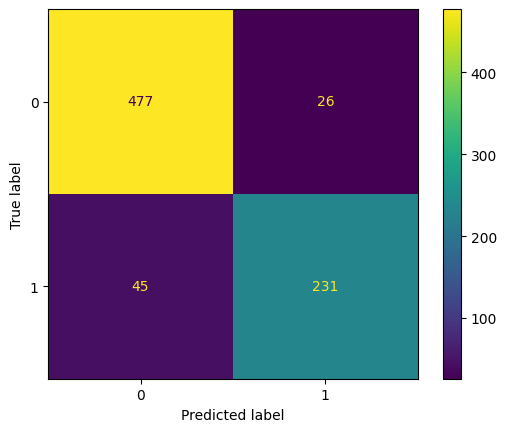

In [38]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test_stem, y_test)

In [43]:
import optuna
from optuna.pruners import MedianPruner
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Define the pipeline creation function
def get_pipeline(percentile: int, **hyperparams) -> Pipeline:
    '''Pipeline we use for our model.'''
    print("Creating pipeline with hyperparameters:", hyperparams)
    print(f'Selecting best {percentile} percent of features.')
    selector = SelectPercentile(chi2, percentile=percentile)
    pipeline = Pipeline([
        ('selector', selector),
        ('classifier', SGDClassifier(**hyperparams))
    ])
    print("Pipeline created.")
    return pipeline

# Objective function for Optuna
def objective(trial):
    percentile = trial.suggest_int('percentile', 25, 75)
    hyperparams = {
        'loss': trial.suggest_categorical('loss', ['hinge', 'log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 1e-4, 1e-2),
        'max_iter': trial.suggest_int('max_iter', 1000, 5000),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'invscaling', 'adaptive']),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1),
        'power_t': trial.suggest_float('power_t', 0.25, 0.75)
    }
    best_params = {'percentile': percentile, **hyperparams}
    pipeline = get_pipeline(**best_params)
    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train_stem, y_train, cv=3, scoring='accuracy')
    
    # Return the average accuracy
    trial.report(scores.mean(), step=0)
    
    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    return scores.mean()

# Create the study with MedianPruner and optimize
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=1, interval_steps=1)
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=100)

# Output the best hyperparameters
best_params = study.best_params
print("Best hyperparameters: ", best_params)

# Create the pipeline with the best hyperparameters
pipeline = get_pipeline(**best_params)
pipeline.fit(X_train_stem, y_train)

# Make predictions and evaluate the model (optional)
predictions = pipeline.predict(X_test_stem)
print(classification_report(y_test, predictions))


[I 2025-02-01 12:39:10,025] A new study created in memory with name: no-name-1e71b608-abf7-4dd7-baff-2e9709203300


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0015055372408307767, 'max_iter': 1009, 'learning_rate': 'adaptive', 'eta0': 0.09978423460701503, 'power_t': 0.2994077450531438}
Selecting best 38 percent of features.
Pipeline created.


[I 2025-02-01 12:39:11,058] Trial 0 finished with value: 0.8263281167418649 and parameters: {'percentile': 38, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0015055372408307767, 'max_iter': 1009, 'learning_rate': 'adaptive', 'eta0': 0.09978423460701503, 'power_t': 0.2994077450531438}. Best is trial 0 with value: 0.8263281167418649.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0007832289106603601, 'max_iter': 4715, 'learning_rate': 'constant', 'eta0': 0.03041126468882792, 'power_t': 0.5101844308217008}
Selecting best 52 percent of features.
Pipeline created.


[I 2025-02-01 12:39:12,195] Trial 1 finished with value: 0.8240798950129286 and parameters: {'percentile': 52, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0007832289106603601, 'max_iter': 4715, 'learning_rate': 'constant', 'eta0': 0.03041126468882792, 'power_t': 0.5101844308217008}. Best is trial 0 with value: 0.8263281167418649.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.004942956044208402, 'max_iter': 4032, 'learning_rate': 'constant', 'eta0': 0.03406326810314737, 'power_t': 0.5627834832095628}
Selecting best 35 percent of features.
Pipeline created.


[I 2025-02-01 12:39:13,136] Trial 2 finished with value: 0.6218298806408761 and parameters: {'percentile': 35, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.004942956044208402, 'max_iter': 4032, 'learning_rate': 'constant', 'eta0': 0.03406326810314737, 'power_t': 0.5627834832095628}. Best is trial 0 with value: 0.8263281167418649.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0054802618705758485, 'max_iter': 2531, 'learning_rate': 'adaptive', 'eta0': 0.04315141810653541, 'power_t': 0.475674258571772}
Selecting best 37 percent of features.
Pipeline created.


[I 2025-02-01 12:39:14,116] Trial 3 finished with value: 0.623435223459146 and parameters: {'percentile': 37, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0054802618705758485, 'max_iter': 2531, 'learning_rate': 'adaptive', 'eta0': 0.04315141810653541, 'power_t': 0.475674258571772}. Best is trial 0 with value: 0.8263281167418649.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.009181573402330338, 'max_iter': 2287, 'learning_rate': 'constant', 'eta0': 0.005811426547671677, 'power_t': 0.364169788426724}
Selecting best 32 percent of features.
Pipeline created.


[I 2025-02-01 12:39:15,064] Trial 4 finished with value: 0.6218298806408761 and parameters: {'percentile': 32, 'loss': 'log_loss', 'penalty': 'l1', 'alpha': 0.009181573402330338, 'max_iter': 2287, 'learning_rate': 'constant', 'eta0': 0.005811426547671677, 'power_t': 0.364169788426724}. Best is trial 0 with value: 0.8263281167418649.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.001469210850734717, 'max_iter': 4700, 'learning_rate': 'optimal', 'eta0': 0.01128072890775695, 'power_t': 0.3320912899667724}
Selecting best 74 percent of features.
Pipeline created.


[I 2025-02-01 12:39:16,027] Trial 5 finished with value: 0.834351121916422 and parameters: {'percentile': 74, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.001469210850734717, 'max_iter': 4700, 'learning_rate': 'optimal', 'eta0': 0.01128072890775695, 'power_t': 0.3320912899667724}. Best is trial 5 with value: 0.834351121916422.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0040309294127272195, 'max_iter': 3658, 'learning_rate': 'invscaling', 'eta0': 0.05612104391074583, 'power_t': 0.3979054223045642}
Selecting best 57 percent of features.
Pipeline created.


[I 2025-02-01 12:39:17,164] Trial 6 finished with value: 0.6218298806408761 and parameters: {'percentile': 57, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.0040309294127272195, 'max_iter': 3658, 'learning_rate': 'invscaling', 'eta0': 0.05612104391074583, 'power_t': 0.3979054223045642}. Best is trial 5 with value: 0.834351121916422.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0017186136117686348, 'max_iter': 2518, 'learning_rate': 'invscaling', 'eta0': 0.08731064112108096, 'power_t': 0.7343497629640716}
Selecting best 31 percent of features.
Pipeline created.


[I 2025-02-01 12:39:18,127] Trial 7 finished with value: 0.6218298806408761 and parameters: {'percentile': 31, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0017186136117686348, 'max_iter': 2518, 'learning_rate': 'invscaling', 'eta0': 0.08731064112108096, 'power_t': 0.7343497629640716}. Best is trial 5 with value: 0.834351121916422.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0011619264214153867, 'max_iter': 3264, 'learning_rate': 'optimal', 'eta0': 0.09945462713747343, 'power_t': 0.3518826218419215}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:39:19,069] Trial 8 finished with value: 0.8417334117151083 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0011619264214153867, 'max_iter': 3264, 'learning_rate': 'optimal', 'eta0': 0.09945462713747343, 'power_t': 0.3518826218419215}. Best is trial 8 with value: 0.8417334117151083.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.006272871861005176, 'max_iter': 2943, 'learning_rate': 'constant', 'eta0': 0.07616752903359532, 'power_t': 0.28241357533918265}
Selecting best 63 percent of features.
Pipeline created.


[I 2025-02-01 12:39:20,089] Trial 9 finished with value: 0.6324169836245143 and parameters: {'percentile': 63, 'loss': 'hinge', 'penalty': 'l1', 'alpha': 0.006272871861005176, 'max_iter': 2943, 'learning_rate': 'constant', 'eta0': 0.07616752903359532, 'power_t': 0.28241357533918265}. Best is trial 8 with value: 0.8417334117151083.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0032915745828101424, 'max_iter': 1515, 'learning_rate': 'optimal', 'eta0': 0.06030684013130896, 'power_t': 0.6401790398142213}
Selecting best 45 percent of features.
Pipeline created.


[I 2025-02-01 12:39:21,064] Trial 10 finished with value: 0.8359567738110912 and parameters: {'percentile': 45, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0032915745828101424, 'max_iter': 1515, 'learning_rate': 'optimal', 'eta0': 0.06030684013130896, 'power_t': 0.6401790398142213}. Best is trial 8 with value: 0.8417334117151083.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.003401702100982828, 'max_iter': 1259, 'learning_rate': 'optimal', 'eta0': 0.06488846942027432, 'power_t': 0.6627534702019979}
Selecting best 46 percent of features.
Pipeline created.


[I 2025-02-01 12:39:22,078] Trial 11 finished with value: 0.8343523582220195 and parameters: {'percentile': 46, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.003401702100982828, 'max_iter': 1259, 'learning_rate': 'optimal', 'eta0': 0.06488846942027432, 'power_t': 0.6627534702019979}. Best is trial 8 with value: 0.8417334117151083.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0027529552526723315, 'max_iter': 1705, 'learning_rate': 'optimal', 'eta0': 0.09975307751765583, 'power_t': 0.617460913498665}
Selecting best 47 percent of features.
Pipeline created.


[I 2025-02-01 12:39:23,092] Trial 12 finished with value: 0.843019169536441 and parameters: {'percentile': 47, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0027529552526723315, 'max_iter': 1705, 'learning_rate': 'optimal', 'eta0': 0.09975307751765583, 'power_t': 0.617460913498665}. Best is trial 12 with value: 0.843019169536441.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.000244265645452614, 'max_iter': 1860, 'learning_rate': 'optimal', 'eta0': 0.09971582139762727, 'power_t': 0.4450016969730368}
Selecting best 59 percent of features.
Pipeline created.


[I 2025-02-01 12:39:24,139] Trial 13 finished with value: 0.8914934757062859 and parameters: {'percentile': 59, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.000244265645452614, 'max_iter': 1860, 'learning_rate': 'optimal', 'eta0': 0.09971582139762727, 'power_t': 0.4450016969730368}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001887222629698698, 'max_iter': 1865, 'learning_rate': 'optimal', 'eta0': 0.08369849485275407, 'power_t': 0.4406361767941393}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-01 12:39:25,136] Trial 14 finished with value: 0.8895670025090823 and parameters: {'percentile': 65, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0001887222629698698, 'max_iter': 1865, 'learning_rate': 'optimal', 'eta0': 0.08369849485275407, 'power_t': 0.4406361767941393}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00012611654007905506, 'max_iter': 1870, 'learning_rate': 'optimal', 'eta0': 0.07860686335907455, 'power_t': 0.4341846754404276}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-01 12:39:26,134] Trial 15 finished with value: 0.8898881328880162 and parameters: {'percentile': 67, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00012611654007905506, 'max_iter': 1870, 'learning_rate': 'optimal', 'eta0': 0.07860686335907455, 'power_t': 0.4341846754404276}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008311862975874967, 'max_iter': 1861, 'learning_rate': 'optimal', 'eta0': 0.07156152533168694, 'power_t': 0.5243552451562512}
Selecting best 74 percent of features.
Pipeline created.


[I 2025-02-01 12:39:27,131] Trial 16 finished with value: 0.7364431364331224 and parameters: {'percentile': 74, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008311862975874967, 'max_iter': 1861, 'learning_rate': 'optimal', 'eta0': 0.07156152533168694, 'power_t': 0.5243552451562512}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00013904238471008042, 'max_iter': 2194, 'learning_rate': 'optimal', 'eta0': 0.08399108404747746, 'power_t': 0.4266602346706801}
Selecting best 66 percent of features.
Pipeline created.


[I 2025-02-01 12:39:28,145] Trial 17 finished with value: 0.8886033022958814 and parameters: {'percentile': 66, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00013904238471008042, 'max_iter': 2194, 'learning_rate': 'optimal', 'eta0': 0.08399108404747746, 'power_t': 0.4266602346706801}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.007193683609919667, 'max_iter': 2869, 'learning_rate': 'invscaling', 'eta0': 0.08735876370056565, 'power_t': 0.5598961714317857}
Selecting best 58 percent of features.
Pipeline created.


[I 2025-02-01 12:39:29,347] Trial 18 finished with value: 0.6260036483378181 and parameters: {'percentile': 58, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.007193683609919667, 'max_iter': 2869, 'learning_rate': 'invscaling', 'eta0': 0.08735876370056565, 'power_t': 0.5598961714317857}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0023542456310252, 'max_iter': 1310, 'learning_rate': 'adaptive', 'eta0': 0.0731910406491407, 'power_t': 0.4563165256560667}
Selecting best 25 percent of features.
Pipeline created.


[I 2025-02-01 12:39:30,373] Trial 19 finished with value: 0.8526515355224596 and parameters: {'percentile': 25, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0023542456310252, 'max_iter': 1310, 'learning_rate': 'adaptive', 'eta0': 0.0731910406491407, 'power_t': 0.4563165256560667}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.004407856334708691, 'max_iter': 2021, 'learning_rate': 'optimal', 'eta0': 0.04200653815230019, 'power_t': 0.3960579030172989}
Selecting best 69 percent of features.
Pipeline created.


[I 2025-02-01 12:39:31,410] Trial 20 finished with value: 0.8144484562561081 and parameters: {'percentile': 69, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.004407856334708691, 'max_iter': 2021, 'learning_rate': 'optimal', 'eta0': 0.04200653815230019, 'power_t': 0.3960579030172989}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005978683013768251, 'max_iter': 1810, 'learning_rate': 'optimal', 'eta0': 0.08481151929449003, 'power_t': 0.42753514668962356}
Selecting best 60 percent of features.
Pipeline created.


[I 2025-02-01 12:39:32,416] Trial 21 finished with value: 0.8853957074233351 and parameters: {'percentile': 60, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005978683013768251, 'max_iter': 1810, 'learning_rate': 'optimal', 'eta0': 0.08481151929449003, 'power_t': 0.42753514668962356}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00017110210774934307, 'max_iter': 2521, 'learning_rate': 'optimal', 'eta0': 0.09168471810981471, 'power_t': 0.46314201453244686}
Selecting best 69 percent of features.
Pipeline created.


[I 2025-02-01 12:39:33,430] Trial 22 finished with value: 0.891172345327352 and parameters: {'percentile': 69, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00017110210774934307, 'max_iter': 2521, 'learning_rate': 'optimal', 'eta0': 0.09168471810981471, 'power_t': 0.46314201453244686}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002051248545110205, 'max_iter': 2584, 'learning_rate': 'optimal', 'eta0': 0.09245181148793889, 'power_t': 0.49598871863233673}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:39:34,444] Trial 23 finished with value: 0.8552193422483331 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.002051248545110205, 'max_iter': 2584, 'learning_rate': 'optimal', 'eta0': 0.09245181148793889, 'power_t': 0.49598871863233673}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008575751179886611, 'max_iter': 3244, 'learning_rate': 'optimal', 'eta0': 0.07672637115487987, 'power_t': 0.5620719274308975}
Selecting best 55 percent of features.
Pipeline created.


[I 2025-02-01 12:39:35,448] Trial 24 finished with value: 0.882184712710396 and parameters: {'percentile': 55, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008575751179886611, 'max_iter': 3244, 'learning_rate': 'optimal', 'eta0': 0.07672637115487987, 'power_t': 0.5620719274308975}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0028636480099014914, 'max_iter': 2202, 'learning_rate': 'optimal', 'eta0': 0.09311283820990025, 'power_t': 0.3903275723887448}
Selecting best 62 percent of features.
Pipeline created.


[I 2025-02-01 12:39:36,489] Trial 25 finished with value: 0.8420560874760389 and parameters: {'percentile': 62, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0028636480099014914, 'max_iter': 2202, 'learning_rate': 'optimal', 'eta0': 0.09311283820990025, 'power_t': 0.3903275723887448}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00017928310749023644, 'max_iter': 1473, 'learning_rate': 'optimal', 'eta0': 0.06669206701753644, 'power_t': 0.4685108528132878}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:39:37,470] Trial 26 finished with value: 0.8905291573402864 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00017928310749023644, 'max_iter': 1473, 'learning_rate': 'optimal', 'eta0': 0.06669206701753644, 'power_t': 0.4685108528132878}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0020227813607031162, 'max_iter': 1495, 'learning_rate': 'invscaling', 'eta0': 0.06374886141583752, 'power_t': 0.5304595954105231}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-01 12:39:38,666] Trial 27 finished with value: 0.6870008029804855 and parameters: {'percentile': 71, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0020227813607031162, 'max_iter': 1495, 'learning_rate': 'invscaling', 'eta0': 0.06374886141583752, 'power_t': 0.5304595954105231}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0010837501270787998, 'max_iter': 1071, 'learning_rate': 'adaptive', 'eta0': 0.05115407005924829, 'power_t': 0.5998919947147436}
Selecting best 75 percent of features.
Pipeline created.


[I 2025-02-01 12:39:39,814] Trial 28 finished with value: 0.7871628826443094 and parameters: {'percentile': 75, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0010837501270787998, 'max_iter': 1071, 'learning_rate': 'adaptive', 'eta0': 0.05115407005924829, 'power_t': 0.5998919947147436}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0016271043757174995, 'max_iter': 1095, 'learning_rate': 'adaptive', 'eta0': 0.09366178796451459, 'power_t': 0.3186303503216074}
Selecting best 62 percent of features.
Pipeline created.


[I 2025-02-01 12:39:40,877] Trial 29 finished with value: 0.821834764047986 and parameters: {'percentile': 62, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0016271043757174995, 'max_iter': 1095, 'learning_rate': 'adaptive', 'eta0': 0.09366178796451459, 'power_t': 0.3186303503216074}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0039014962368465024, 'max_iter': 1560, 'learning_rate': 'optimal', 'eta0': 0.07052476851084102, 'power_t': 0.263476049766172}
Selecting best 55 percent of features.
Pipeline created.


[I 2025-02-01 12:39:41,874] Trial 30 finished with value: 0.6346720050342364 and parameters: {'percentile': 55, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0039014962368465024, 'max_iter': 1560, 'learning_rate': 'optimal', 'eta0': 0.07052476851084102, 'power_t': 0.263476049766172}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0001099945139668572, 'max_iter': 2118, 'learning_rate': 'optimal', 'eta0': 0.07920026394705103, 'power_t': 0.47836484783120065}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-01 12:39:42,855] Trial 31 finished with value: 0.8902104995725472 and parameters: {'percentile': 67, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0001099945139668572, 'max_iter': 2118, 'learning_rate': 'optimal', 'eta0': 0.07920026394705103, 'power_t': 0.47836484783120065}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007305699799223138, 'max_iter': 2347, 'learning_rate': 'optimal', 'eta0': 0.0942886217171367, 'power_t': 0.47636783583672104}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:39:43,835] Trial 32 finished with value: 0.8860351864936087 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007305699799223138, 'max_iter': 2347, 'learning_rate': 'optimal', 'eta0': 0.0942886217171367, 'power_t': 0.47636783583672104}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007888360411229521, 'max_iter': 2741, 'learning_rate': 'optimal', 'eta0': 0.08013341136634468, 'power_t': 0.4832774247954883}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-01 12:39:44,832] Trial 33 finished with value: 0.8863578622545393 and parameters: {'percentile': 65, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0007888360411229521, 'max_iter': 2741, 'learning_rate': 'optimal', 'eta0': 0.08013341136634468, 'power_t': 0.4832774247954883}. Best is trial 13 with value: 0.8914934757062859.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00011946542825129946, 'max_iter': 2036, 'learning_rate': 'constant', 'eta0': 0.06755231746907625, 'power_t': 0.5242493914782964}
Selecting best 72 percent of features.
Pipeline created.


[I 2025-02-01 12:39:45,912] Trial 34 finished with value: 0.8943830309638918 and parameters: {'percentile': 72, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00011946542825129946, 'max_iter': 2036, 'learning_rate': 'constant', 'eta0': 0.06755231746907625, 'power_t': 0.5242493914782964}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001424158053181215, 'max_iter': 1470, 'learning_rate': 'constant', 'eta0': 0.022353121398671943, 'power_t': 0.5375704065686778}
Selecting best 72 percent of features.
Pipeline created.


[I 2025-02-01 12:39:46,993] Trial 35 finished with value: 0.7585903149055803 and parameters: {'percentile': 72, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.001424158053181215, 'max_iter': 1470, 'learning_rate': 'constant', 'eta0': 0.022353121398671943, 'power_t': 0.5375704065686778}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.009979635459785925, 'max_iter': 3165, 'learning_rate': 'constant', 'eta0': 0.0466580631400805, 'power_t': 0.5052369402411802}
Selecting best 73 percent of features.
Pipeline created.


[I 2025-02-01 12:39:48,024] Trial 36 finished with value: 0.7804191446866985 and parameters: {'percentile': 73, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.009979635459785925, 'max_iter': 3165, 'learning_rate': 'constant', 'eta0': 0.0466580631400805, 'power_t': 0.5052369402411802}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0024221934995024975, 'max_iter': 2473, 'learning_rate': 'constant', 'eta0': 0.03582391994703049, 'power_t': 0.4583232606361346}
Selecting best 60 percent of features.
Pipeline created.


[I 2025-02-01 12:39:49,088] Trial 37 finished with value: 0.7476759000150212 and parameters: {'percentile': 60, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0024221934995024975, 'max_iter': 2473, 'learning_rate': 'constant', 'eta0': 0.03582391994703049, 'power_t': 0.4583232606361346}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0051509611939665675, 'max_iter': 3818, 'learning_rate': 'constant', 'eta0': 0.06678944428580315, 'power_t': 0.5791834128602188}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-01 12:39:50,166] Trial 38 finished with value: 0.6240771751406143 and parameters: {'percentile': 68, 'loss': 'log_loss', 'penalty': 'l2', 'alpha': 0.0051509611939665675, 'max_iter': 3818, 'learning_rate': 'constant', 'eta0': 0.06678944428580315, 'power_t': 0.5791834128602188}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0006744987842690692, 'max_iter': 4855, 'learning_rate': 'constant', 'eta0': 0.055483368065808454, 'power_t': 0.3626089660413942}
Selecting best 42 percent of features.
Pipeline created.


[I 2025-02-01 12:39:51,331] Trial 39 finished with value: 0.8606720680858219 and parameters: {'percentile': 42, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0006744987842690692, 'max_iter': 4855, 'learning_rate': 'constant', 'eta0': 0.055483368065808454, 'power_t': 0.3626089660413942}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0014857072169071285, 'max_iter': 2023, 'learning_rate': 'constant', 'eta0': 0.059749863060069366, 'power_t': 0.4014657734948654}
Selecting best 64 percent of features.
Pipeline created.


[I 2025-02-01 12:39:52,362] Trial 40 finished with value: 0.8764062203479829 and parameters: {'percentile': 64, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0014857072169071285, 'max_iter': 2023, 'learning_rate': 'constant', 'eta0': 0.059749863060069366, 'power_t': 0.4014657734948654}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00043181840080568144, 'max_iter': 2145, 'learning_rate': 'optimal', 'eta0': 0.08891678687884885, 'power_t': 0.45801463633936645}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-01 12:39:53,359] Trial 41 finished with value: 0.8895676206618809 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00043181840080568144, 'max_iter': 2145, 'learning_rate': 'optimal', 'eta0': 0.08891678687884885, 'power_t': 0.45801463633936645}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0011501909036337947, 'max_iter': 2698, 'learning_rate': 'invscaling', 'eta0': 0.081363781466318, 'power_t': 0.5112297531715981}
Selecting best 75 percent of features.
Pipeline created.


[I 2025-02-01 12:39:54,655] Trial 42 finished with value: 0.7611584307078529 and parameters: {'percentile': 75, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0011501909036337947, 'max_iter': 2698, 'learning_rate': 'invscaling', 'eta0': 0.081363781466318, 'power_t': 0.5112297531715981}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0003971281106859403, 'max_iter': 4324, 'learning_rate': 'optimal', 'eta0': 0.09674213077229217, 'power_t': 0.48857586266174036}
Selecting best 72 percent of features.
Pipeline created.


[I 2025-02-01 12:39:55,703] Trial 43 finished with value: 0.8886045386014788 and parameters: {'percentile': 72, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0003971281106859403, 'max_iter': 4324, 'learning_rate': 'optimal', 'eta0': 0.09674213077229217, 'power_t': 0.48857586266174036}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0011081430606801079, 'max_iter': 2391, 'learning_rate': 'optimal', 'eta0': 0.08942269193187122, 'power_t': 0.5363845346195923}
Selecting best 53 percent of features.
Pipeline created.


[I 2025-02-01 12:39:56,733] Trial 44 finished with value: 0.8426968028519098 and parameters: {'percentile': 53, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0011081430606801079, 'max_iter': 2391, 'learning_rate': 'optimal', 'eta0': 0.08942269193187122, 'power_t': 0.5363845346195923}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0062002622855382855, 'max_iter': 1630, 'learning_rate': 'adaptive', 'eta0': 0.06923469854032277, 'power_t': 0.4107409550860211}
Selecting best 60 percent of features.
Pipeline created.


[I 2025-02-01 12:39:57,819] Trial 45 finished with value: 0.8163749294533119 and parameters: {'percentile': 60, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0062002622855382855, 'max_iter': 1630, 'learning_rate': 'adaptive', 'eta0': 0.06923469854032277, 'power_t': 0.4107409550860211}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00041578317896482633, 'max_iter': 1305, 'learning_rate': 'optimal', 'eta0': 0.0739632783625023, 'power_t': 0.46243638416034716}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-01 12:39:58,844] Trial 46 finished with value: 0.8892477265885445 and parameters: {'percentile': 67, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.00041578317896482633, 'max_iter': 1305, 'learning_rate': 'optimal', 'eta0': 0.0739632783625023, 'power_t': 0.46243638416034716}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00198473471243935, 'max_iter': 2031, 'learning_rate': 'constant', 'eta0': 0.09910088807063852, 'power_t': 0.6816677827425097}
Selecting best 63 percent of features.
Pipeline created.


[I 2025-02-01 12:39:59,925] Trial 47 finished with value: 0.6664527857983104 and parameters: {'percentile': 63, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00198473471243935, 'max_iter': 2031, 'learning_rate': 'constant', 'eta0': 0.09910088807063852, 'power_t': 0.6816677827425097}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012730299816317756, 'max_iter': 1759, 'learning_rate': 'optimal', 'eta0': 0.061034469601894764, 'power_t': 0.3724170432872931}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:00,988] Trial 48 finished with value: 0.8748002593769145 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0012730299816317756, 'max_iter': 1759, 'learning_rate': 'optimal', 'eta0': 0.061034469601894764, 'power_t': 0.3724170432872931}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.00011650497128698536, 'max_iter': 2642, 'learning_rate': 'optimal', 'eta0': 0.0780902375289025, 'power_t': 0.44235557174103135}
Selecting best 66 percent of features.
Pipeline created.


[I 2025-02-01 12:40:02,051] Trial 49 finished with value: 0.8706261826035732 and parameters: {'percentile': 66, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.00011650497128698536, 'max_iter': 2642, 'learning_rate': 'optimal', 'eta0': 0.0780902375289025, 'power_t': 0.44235557174103135}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0008643414952940479, 'max_iter': 2282, 'learning_rate': 'invscaling', 'eta0': 0.08943841431132005, 'power_t': 0.5192696077976791}
Selecting best 50 percent of features.
Pipeline created.


[I 2025-02-01 12:40:03,271] Trial 50 finished with value: 0.7653325074811942 and parameters: {'percentile': 50, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0008643414952940479, 'max_iter': 2282, 'learning_rate': 'invscaling', 'eta0': 0.08943841431132005, 'power_t': 0.5192696077976791}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00023787012161008555, 'max_iter': 1933, 'learning_rate': 'optimal', 'eta0': 0.08212370188295605, 'power_t': 0.4190249337912369}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-01 12:40:04,346] Trial 51 finished with value: 0.8934205670562884 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00023787012161008555, 'max_iter': 1933, 'learning_rate': 'optimal', 'eta0': 0.08212370188295605, 'power_t': 0.4190249337912369}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011727405643884325, 'max_iter': 1946, 'learning_rate': 'optimal', 'eta0': 0.08015187057406245, 'power_t': 0.41680230288291054}
Selecting best 72 percent of features.
Pipeline created.


[I 2025-02-01 12:40:05,416] Trial 52 finished with value: 0.8934177853686943 and parameters: {'percentile': 72, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011727405643884325, 'max_iter': 1946, 'learning_rate': 'optimal', 'eta0': 0.08015187057406245, 'power_t': 0.41680230288291054}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005201789818338258, 'max_iter': 1686, 'learning_rate': 'optimal', 'eta0': 0.08449486981168952, 'power_t': 0.4135171184445422}
Selecting best 72 percent of features.
Pipeline created.


[I 2025-02-01 12:40:06,490] Trial 53 finished with value: 0.8850733407388037 and parameters: {'percentile': 72, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005201789818338258, 'max_iter': 1686, 'learning_rate': 'optimal', 'eta0': 0.08449486981168952, 'power_t': 0.4135171184445422}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0017446440389595906, 'max_iter': 1406, 'learning_rate': 'optimal', 'eta0': 0.07476059107250331, 'power_t': 0.3364065328343938}
Selecting best 74 percent of features.
Pipeline created.


[I 2025-02-01 12:40:07,588] Trial 54 finished with value: 0.8597120767894132 and parameters: {'percentile': 74, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0017446440389595906, 'max_iter': 1406, 'learning_rate': 'optimal', 'eta0': 0.07476059107250331, 'power_t': 0.3364065328343938}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009995596430152794, 'max_iter': 1935, 'learning_rate': 'optimal', 'eta0': 0.08295074331135772, 'power_t': 0.37669744119834403}
Selecting best 69 percent of features.
Pipeline created.


[I 2025-02-01 12:40:08,701] Trial 55 finished with value: 0.875441592905584 and parameters: {'percentile': 69, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009995596430152794, 'max_iter': 1935, 'learning_rate': 'optimal', 'eta0': 0.08295074331135772, 'power_t': 0.37669744119834403}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008199079784905403, 'max_iter': 1773, 'learning_rate': 'optimal', 'eta0': 0.09688737070927281, 'power_t': 0.446051787164489}
Selecting best 73 percent of features.
Pipeline created.


[I 2025-02-01 12:40:09,764] Trial 56 finished with value: 0.7361216969777891 and parameters: {'percentile': 73, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.008199079784905403, 'max_iter': 1773, 'learning_rate': 'optimal', 'eta0': 0.09688737070927281, 'power_t': 0.446051787164489}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005078708636931205, 'max_iter': 1941, 'learning_rate': 'optimal', 'eta0': 0.0012951827035366029, 'power_t': 0.42926675435150347}
Selecting best 58 percent of features.
Pipeline created.


[I 2025-02-01 12:40:10,829] Trial 57 finished with value: 0.8850730316624045 and parameters: {'percentile': 58, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005078708636931205, 'max_iter': 1941, 'learning_rate': 'optimal', 'eta0': 0.0012951827035366029, 'power_t': 0.42926675435150347}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0017307435360036734, 'max_iter': 2893, 'learning_rate': 'adaptive', 'eta0': 0.06737715734899007, 'power_t': 0.41718402429299617}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-01 12:40:12,158] Trial 58 finished with value: 0.8626019411234185 and parameters: {'percentile': 65, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0017307435360036734, 'max_iter': 2893, 'learning_rate': 'adaptive', 'eta0': 0.06737715734899007, 'power_t': 0.41718402429299617}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0026286286968849304, 'max_iter': 3086, 'learning_rate': 'optimal', 'eta0': 0.08672577348441625, 'power_t': 0.3891749407696631}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:13,245] Trial 59 finished with value: 0.8443027638229784 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0026286286968849304, 'max_iter': 3086, 'learning_rate': 'optimal', 'eta0': 0.08672577348441625, 'power_t': 0.3891749407696631}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00010264802435483016, 'max_iter': 3429, 'learning_rate': 'constant', 'eta0': 0.06248058594275816, 'power_t': 0.5471555217286911}
Selecting best 75 percent of features.
Pipeline created.


[I 2025-02-01 12:40:14,801] Trial 60 finished with value: 0.8731955347114432 and parameters: {'percentile': 75, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00010264802435483016, 'max_iter': 3429, 'learning_rate': 'constant', 'eta0': 0.06248058594275816, 'power_t': 0.5471555217286911}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00033772417287234987, 'max_iter': 2455, 'learning_rate': 'optimal', 'eta0': 0.07878344264713076, 'power_t': 0.46975962032155955}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-01 12:40:15,898] Trial 61 finished with value: 0.8908509058720188 and parameters: {'percentile': 67, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00033772417287234987, 'max_iter': 2455, 'learning_rate': 'optimal', 'eta0': 0.07878344264713076, 'power_t': 0.46975962032155955}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008762246262877315, 'max_iter': 2472, 'learning_rate': 'optimal', 'eta0': 0.09189369107908309, 'power_t': 0.5073480396157802}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-01 12:40:16,962] Trial 62 finished with value: 0.8818638914078615 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008762246262877315, 'max_iter': 2472, 'learning_rate': 'optimal', 'eta0': 0.09189369107908309, 'power_t': 0.5073480396157802}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0004994212966809797, 'max_iter': 2268, 'learning_rate': 'optimal', 'eta0': 0.07544742158885742, 'power_t': 0.47136286671668626}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-01 12:40:18,042] Trial 63 finished with value: 0.8876411474646771 and parameters: {'percentile': 71, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0004994212966809797, 'max_iter': 2268, 'learning_rate': 'optimal', 'eta0': 0.07544742158885742, 'power_t': 0.47136286671668626}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0011864523030510866, 'max_iter': 1157, 'learning_rate': 'optimal', 'eta0': 0.056562397810644593, 'power_t': 0.4442380901137968}
Selecting best 62 percent of features.
Pipeline created.


[I 2025-02-01 12:40:19,086] Trial 64 finished with value: 0.8719110131957079 and parameters: {'percentile': 62, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0011864523030510866, 'max_iter': 1157, 'learning_rate': 'optimal', 'eta0': 0.056562397810644593, 'power_t': 0.4442380901137968}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0003581429491235411, 'max_iter': 2073, 'learning_rate': 'optimal', 'eta0': 0.0812704235257854, 'power_t': 0.5812007065708422}
Selecting best 66 percent of features.
Pipeline created.


[I 2025-02-01 12:40:20,219] Trial 65 finished with value: 0.8825049158601318 and parameters: {'percentile': 66, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0003581429491235411, 'max_iter': 2073, 'learning_rate': 'optimal', 'eta0': 0.0812704235257854, 'power_t': 0.5812007065708422}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006503142885873182, 'max_iter': 1881, 'learning_rate': 'optimal', 'eta0': 0.07022458153444466, 'power_t': 0.3498984371489668}
Selecting best 64 percent of features.
Pipeline created.


[I 2025-02-01 12:40:21,266] Trial 66 finished with value: 0.8844316981337349 and parameters: {'percentile': 64, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006503142885873182, 'max_iter': 1881, 'learning_rate': 'optimal', 'eta0': 0.07022458153444466, 'power_t': 0.3498984371489668}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0013474625956061423, 'max_iter': 1608, 'learning_rate': 'invscaling', 'eta0': 0.08514501751344608, 'power_t': 0.49532368273916544}
Selecting best 73 percent of features.
Pipeline created.


[I 2025-02-01 12:40:23,045] Trial 67 finished with value: 0.7614798701631861 and parameters: {'percentile': 73, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0013474625956061423, 'max_iter': 1608, 'learning_rate': 'invscaling', 'eta0': 0.08514501751344608, 'power_t': 0.49532368273916544}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009649361947914282, 'max_iter': 2819, 'learning_rate': 'optimal', 'eta0': 0.0962451095324648, 'power_t': 0.46991097342279065}
Selecting best 69 percent of features.
Pipeline created.


[I 2025-02-01 12:40:24,092] Trial 68 finished with value: 0.8748002593769143 and parameters: {'percentile': 69, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0009649361947914282, 'max_iter': 2819, 'learning_rate': 'optimal', 'eta0': 0.0962451095324648, 'power_t': 0.46991097342279065}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0030447286161546234, 'max_iter': 2560, 'learning_rate': 'optimal', 'eta0': 0.09143446220916418, 'power_t': 0.42795085470943744}
Selecting best 72 percent of features.
Pipeline created.


[I 2025-02-01 12:40:25,189] Trial 69 finished with value: 0.8407715659603036 and parameters: {'percentile': 72, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0030447286161546234, 'max_iter': 2560, 'learning_rate': 'optimal', 'eta0': 0.09143446220916418, 'power_t': 0.42795085470943744}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0021188182495413396, 'max_iter': 2365, 'learning_rate': 'constant', 'eta0': 0.07240070121180477, 'power_t': 0.7471301254521314}
Selecting best 33 percent of features.
Pipeline created.


[I 2025-02-01 12:40:26,308] Trial 70 finished with value: 0.8227929008859984 and parameters: {'percentile': 33, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.0021188182495413396, 'max_iter': 2365, 'learning_rate': 'constant', 'eta0': 0.07240070121180477, 'power_t': 0.7471301254521314}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0002446160183360158, 'max_iter': 2119, 'learning_rate': 'optimal', 'eta0': 0.07782360540743608, 'power_t': 0.48402771846615383}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-01 12:40:27,316] Trial 71 finished with value: 0.8892474175121451 and parameters: {'percentile': 67, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.0002446160183360158, 'max_iter': 2119, 'learning_rate': 'optimal', 'eta0': 0.07782360540743608, 'power_t': 0.48402771846615383}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00019478392121018568, 'max_iter': 2215, 'learning_rate': 'optimal', 'eta0': 0.08081493561349011, 'power_t': 0.45514568149162704}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-01 12:40:28,347] Trial 72 finished with value: 0.8892458721301484 and parameters: {'percentile': 71, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00019478392121018568, 'max_iter': 2215, 'learning_rate': 'optimal', 'eta0': 0.08081493561349011, 'power_t': 0.45514568149162704}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007085419725015743, 'max_iter': 1960, 'learning_rate': 'optimal', 'eta0': 0.08753065109300233, 'power_t': 0.47503103574180716}
Selecting best 67 percent of features.
Pipeline created.


[I 2025-02-01 12:40:29,394] Trial 73 finished with value: 0.8837900555286659 and parameters: {'percentile': 67, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007085419725015743, 'max_iter': 1960, 'learning_rate': 'optimal', 'eta0': 0.08753065109300233, 'power_t': 0.47503103574180716}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00015761030317469442, 'max_iter': 1405, 'learning_rate': 'optimal', 'eta0': 0.06687738212050666, 'power_t': 0.4963988561806837}
Selecting best 25 percent of features.
Pipeline created.


[I 2025-02-01 12:40:30,425] Trial 74 finished with value: 0.8738356319345154 and parameters: {'percentile': 25, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00015761030317469442, 'max_iter': 1405, 'learning_rate': 'optimal', 'eta0': 0.06687738212050666, 'power_t': 0.4963988561806837}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007501753884657903, 'max_iter': 1790, 'learning_rate': 'optimal', 'eta0': 0.014258117102745452, 'power_t': 0.4026170186824677}
Selecting best 69 percent of features.
Pipeline created.


[I 2025-02-01 12:40:31,504] Trial 75 finished with value: 0.8850721044332065 and parameters: {'percentile': 69, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0007501753884657903, 'max_iter': 1790, 'learning_rate': 'optimal', 'eta0': 0.014258117102745452, 'power_t': 0.4026170186824677}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0015061657928070523, 'max_iter': 2140, 'learning_rate': 'optimal', 'eta0': 0.09469164472482462, 'power_t': 0.518001042434279}
Selecting best 61 percent of features.
Pipeline created.


[I 2025-02-01 12:40:32,536] Trial 76 finished with value: 0.8292170538466722 and parameters: {'percentile': 61, 'loss': 'hinge', 'penalty': 'l2', 'alpha': 0.0015061657928070523, 'max_iter': 2140, 'learning_rate': 'optimal', 'eta0': 0.09469164472482462, 'power_t': 0.518001042434279}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00038752705032877227, 'max_iter': 2379, 'learning_rate': 'adaptive', 'eta0': 0.09101441932101181, 'power_t': 0.43661598177735983}
Selecting best 57 percent of features.
Pipeline created.


[I 2025-02-01 12:40:33,932] Trial 77 finished with value: 0.8426992754631045 and parameters: {'percentile': 57, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.00038752705032877227, 'max_iter': 2379, 'learning_rate': 'adaptive', 'eta0': 0.09101441932101181, 'power_t': 0.43661598177735983}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.003698496800503666, 'max_iter': 1649, 'learning_rate': 'optimal', 'eta0': 0.07973706268825657, 'power_t': 0.4193233861456329}
Selecting best 64 percent of features.
Pipeline created.


[I 2025-02-01 12:40:35,045] Trial 78 finished with value: 0.7919782929463203 and parameters: {'percentile': 64, 'loss': 'modified_huber', 'penalty': 'l1', 'alpha': 0.003698496800503666, 'max_iter': 1649, 'learning_rate': 'optimal', 'eta0': 0.07973706268825657, 'power_t': 0.4193233861456329}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.005931805057382389, 'max_iter': 1220, 'learning_rate': 'constant', 'eta0': 0.0995606774313756, 'power_t': 0.5456837135567257}
Selecting best 74 percent of features.
Pipeline created.


[I 2025-02-01 12:40:36,076] Trial 79 finished with value: 0.8391659140656342 and parameters: {'percentile': 74, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.005931805057382389, 'max_iter': 1220, 'learning_rate': 'constant', 'eta0': 0.0995606774313756, 'power_t': 0.5456837135567257}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.000953378165895865, 'max_iter': 2438, 'learning_rate': 'invscaling', 'eta0': 0.07675372979954766, 'power_t': 0.45507014056508144}
Selecting best 66 percent of features.
Pipeline created.


[I 2025-02-01 12:40:37,772] Trial 80 finished with value: 0.8128446588198351 and parameters: {'percentile': 66, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.000953378165895865, 'max_iter': 2438, 'learning_rate': 'invscaling', 'eta0': 0.07675372979954766, 'power_t': 0.45507014056508144}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005894255029085505, 'max_iter': 1840, 'learning_rate': 'optimal', 'eta0': 0.07864631692831123, 'power_t': 0.38519940213429915}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-01 12:40:38,802] Trial 81 finished with value: 0.8892474175121453 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005894255029085505, 'max_iter': 1840, 'learning_rate': 'optimal', 'eta0': 0.07864631692831123, 'power_t': 0.38519940213429915}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0003578399561012031, 'max_iter': 1516, 'learning_rate': 'optimal', 'eta0': 0.08331611912749559, 'power_t': 0.48417134108280335}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:39,849] Trial 82 finished with value: 0.8914925484770878 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0003578399561012031, 'max_iter': 1516, 'learning_rate': 'optimal', 'eta0': 0.08331611912749559, 'power_t': 0.48417134108280335}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.006918964736122268, 'max_iter': 1480, 'learning_rate': 'optimal', 'eta0': 0.08262408606893422, 'power_t': 0.47890104930452165}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-01 12:40:40,935] Trial 83 finished with value: 0.7627662461373177 and parameters: {'percentile': 71, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.006918964736122268, 'max_iter': 1480, 'learning_rate': 'optimal', 'eta0': 0.08262408606893422, 'power_t': 0.47890104930452165}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00010599514052868913, 'max_iter': 1709, 'learning_rate': 'optimal', 'eta0': 0.0859239734353458, 'power_t': 0.4684104468912757}
Selecting best 73 percent of features.
Pipeline created.


[I 2025-02-01 12:40:41,977] Trial 84 finished with value: 0.8905282301110882 and parameters: {'percentile': 73, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00010599514052868913, 'max_iter': 1709, 'learning_rate': 'optimal', 'eta0': 0.0859239734353458, 'power_t': 0.4684104468912757}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00036563693374586304, 'max_iter': 1710, 'learning_rate': 'optimal', 'eta0': 0.08614197431383745, 'power_t': 0.44613783027622056}
Selecting best 73 percent of features.
Pipeline created.


[I 2025-02-01 12:40:43,040] Trial 85 finished with value: 0.887962277843611 and parameters: {'percentile': 73, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00036563693374586304, 'max_iter': 1710, 'learning_rate': 'optimal', 'eta0': 0.08614197431383745, 'power_t': 0.44613783027622056}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.004353222211757451, 'max_iter': 1562, 'learning_rate': 'optimal', 'eta0': 0.08772215617185829, 'power_t': 0.5052965200570697}
Selecting best 75 percent of features.
Pipeline created.


[I 2025-02-01 12:40:44,104] Trial 86 finished with value: 0.8141276349535737 and parameters: {'percentile': 75, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.004353222211757451, 'max_iter': 1562, 'learning_rate': 'optimal', 'eta0': 0.08772215617185829, 'power_t': 0.5052965200570697}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0013477051625066683, 'max_iter': 1426, 'learning_rate': 'optimal', 'eta0': 0.07257271654830733, 'power_t': 0.46365129835615354}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-01 12:40:45,151] Trial 87 finished with value: 0.8725517285715787 and parameters: {'percentile': 71, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0013477051625066683, 'max_iter': 1426, 'learning_rate': 'optimal', 'eta0': 0.07257271654830733, 'power_t': 0.46365129835615354}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006590612484785103, 'max_iter': 1290, 'learning_rate': 'optimal', 'eta0': 0.052302078155367, 'power_t': 0.49075741235300685}
Selecting best 69 percent of features.
Pipeline created.


[I 2025-02-01 12:40:46,218] Trial 88 finished with value: 0.8841099496020023 and parameters: {'percentile': 69, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0006590612484785103, 'max_iter': 1290, 'learning_rate': 'optimal', 'eta0': 0.052302078155367, 'power_t': 0.49075741235300685}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00010489479298001019, 'max_iter': 1986, 'learning_rate': 'constant', 'eta0': 0.09055958923681494, 'power_t': 0.40452855892932676}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:47,345] Trial 89 finished with value: 0.8930988185245559 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00010489479298001019, 'max_iter': 1986, 'learning_rate': 'constant', 'eta0': 0.09055958923681494, 'power_t': 0.40452855892932676}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0011490328687483733, 'max_iter': 1006, 'learning_rate': 'constant', 'eta0': 0.09376879472596035, 'power_t': 0.40112183246233807}
Selecting best 40 percent of features.
Pipeline created.


[I 2025-02-01 12:40:48,459] Trial 90 finished with value: 0.8170181174403778 and parameters: {'percentile': 40, 'loss': 'hinge', 'penalty': 'elasticnet', 'alpha': 0.0011490328687483733, 'max_iter': 1006, 'learning_rate': 'constant', 'eta0': 0.09376879472596035, 'power_t': 0.40112183246233807}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011091171981623922, 'max_iter': 1999, 'learning_rate': 'constant', 'eta0': 0.08954773204058261, 'power_t': 0.42327353412584445}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:49,622] Trial 91 finished with value: 0.893420257979889 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00011091171981623922, 'max_iter': 1999, 'learning_rate': 'constant', 'eta0': 0.08954773204058261, 'power_t': 0.42327353412584445}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0003599275268081286, 'max_iter': 1989, 'learning_rate': 'constant', 'eta0': 0.09696291810594475, 'power_t': 0.4257970974257639}
Selecting best 28 percent of features.
Pipeline created.


[I 2025-02-01 12:40:50,720] Trial 92 finished with value: 0.8853941620413384 and parameters: {'percentile': 28, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0003599275268081286, 'max_iter': 1989, 'learning_rate': 'constant', 'eta0': 0.09696291810594475, 'power_t': 0.4257970974257639}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008293412327345994, 'max_iter': 1881, 'learning_rate': 'constant', 'eta0': 0.09035444892834371, 'power_t': 0.4098894909723354}
Selecting best 68 percent of features.
Pipeline created.


[I 2025-02-01 12:40:51,866] Trial 93 finished with value: 0.8821837854811979 and parameters: {'percentile': 68, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008293412327345994, 'max_iter': 1881, 'learning_rate': 'constant', 'eta0': 0.09035444892834371, 'power_t': 0.4098894909723354}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005455611188832735, 'max_iter': 2241, 'learning_rate': 'constant', 'eta0': 0.0827552110176741, 'power_t': 0.4374846680224383}
Selecting best 71 percent of features.
Pipeline created.


[I 2025-02-01 12:40:53,046] Trial 94 finished with value: 0.8860348774172092 and parameters: {'percentile': 71, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005455611188832735, 'max_iter': 2241, 'learning_rate': 'constant', 'eta0': 0.0827552110176741, 'power_t': 0.4374846680224383}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00030753111976605774, 'max_iter': 2081, 'learning_rate': 'constant', 'eta0': 0.0891996269687266, 'power_t': 0.37961327621403573}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:54,227] Trial 95 finished with value: 0.8911717271745534 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00030753111976605774, 'max_iter': 2081, 'learning_rate': 'constant', 'eta0': 0.0891996269687266, 'power_t': 0.37961327621403573}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00031908860034571935, 'max_iter': 2065, 'learning_rate': 'constant', 'eta0': 0.09564485158153428, 'power_t': 0.3605372171014271}
Selecting best 70 percent of features.
Pipeline created.


[I 2025-02-01 12:40:55,382] Trial 96 finished with value: 0.8882840263753436 and parameters: {'percentile': 70, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.00031908860034571935, 'max_iter': 2065, 'learning_rate': 'constant', 'eta0': 0.09564485158153428, 'power_t': 0.3605372171014271}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0010366640656221905, 'max_iter': 2181, 'learning_rate': 'constant', 'eta0': 0.08963165430025222, 'power_t': 0.3784027199305864}
Selecting best 65 percent of features.
Pipeline created.


[I 2025-02-01 12:40:56,492] Trial 97 finished with value: 0.7688643234966679 and parameters: {'percentile': 65, 'loss': 'log_loss', 'penalty': 'elasticnet', 'alpha': 0.0010366640656221905, 'max_iter': 2181, 'learning_rate': 'constant', 'eta0': 0.08963165430025222, 'power_t': 0.3784027199305864}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005826627314012399, 'max_iter': 2643, 'learning_rate': 'constant', 'eta0': 0.09254347019493563, 'power_t': 0.31722386954069437}
Selecting best 48 percent of features.
Pipeline created.


[I 2025-02-01 12:40:57,584] Trial 98 finished with value: 0.8860376591048035 and parameters: {'percentile': 48, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0005826627314012399, 'max_iter': 2643, 'learning_rate': 'constant', 'eta0': 0.09254347019493563, 'power_t': 0.31722386954069437}. Best is trial 34 with value: 0.8943830309638918.


Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008442944669250072, 'max_iter': 1938, 'learning_rate': 'constant', 'eta0': 0.0839281854732939, 'power_t': 0.41977502055969695}
Selecting best 74 percent of features.
Pipeline created.


[I 2025-02-01 12:40:58,754] Trial 99 finished with value: 0.8786528966949224 and parameters: {'percentile': 74, 'loss': 'modified_huber', 'penalty': 'elasticnet', 'alpha': 0.0008442944669250072, 'max_iter': 1938, 'learning_rate': 'constant', 'eta0': 0.0839281854732939, 'power_t': 0.41977502055969695}. Best is trial 34 with value: 0.8943830309638918.


Best hyperparameters:  {'percentile': 72, 'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00011946542825129946, 'max_iter': 2036, 'learning_rate': 'constant', 'eta0': 0.06755231746907625, 'power_t': 0.5242493914782964}
Creating pipeline with hyperparameters: {'loss': 'modified_huber', 'penalty': 'l2', 'alpha': 0.00011946542825129946, 'max_iter': 2036, 'learning_rate': 'constant', 'eta0': 0.06755231746907625, 'power_t': 0.5242493914782964}
Selecting best 72 percent of features.
Pipeline created.
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       503
           1       0.89      0.84      0.87       276

    accuracy                           0.91       779
   macro avg       0.90      0.89      0.90       779
weighted avg       0.91      0.91      0.91       779



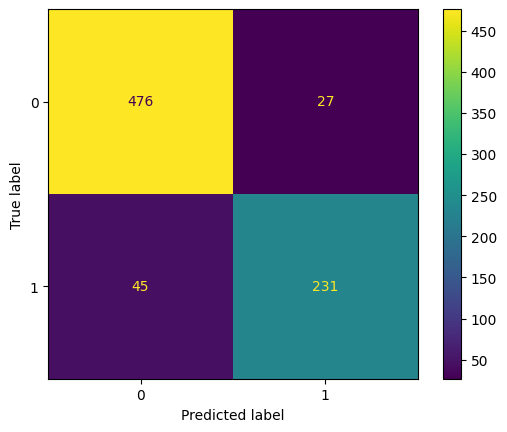

In [41]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test_stem, y_test)

In [42]:
best_params

{'percentile': 63,
 'loss': 'hinge',
 'penalty': 'l2',
 'alpha': 0.0001119231865239663,
 'max_iter': 4482,
 'learning_rate': 'adaptive',
 'eta0': 0.04629708709013644,
 'power_t': 0.5114689016923243}